In [4]:
import os
import time
import uuid
import cv2

In [10]:
IMAGES_PATH  = os.path.join('data','images')
number_images  = 10

In [14]:
# As of now, captured img from phone as there seems some issues with opencv and windows
# below code opens camera and saves images captured in data/image folder
# cap = cv2.VideoCapture(1)
# if cap.isOpened():
#     for imgnum in range(number_images):
#         print("Collecting image {}".format(imgnum))
#         ret, frame = cap.read()
#         imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
#         cv2.imwrite(imgname,frame)
#         cv2.imshow('frame',frame)
#         time.sleep(5)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break
#         cap.release()
#         cv2.destroyAllWindows()


In [15]:
!labelme

2024-06-12 20:50:16,776 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Lenovo\.labelmerc


<h2>Review Dataset and Build image Loading Function</h2>

In [16]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt


In [20]:
# test gpu
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

# tf.test.is_gpu_available()

In [21]:
images = tf.data.Dataset.list_files('data\\images\\*jpg',shuffle=True)

In [22]:
images.as_numpy_iterator().next()

b'data\\images\\IMG_20240612_202734.jpg'

In [23]:
def load_image(x):
    byte_img  = tf.io.read_file(x)
    image = tf.io.decode_jpeg(byte_img)
    return image

In [24]:
images = images.map(load_image)

In [25]:
images.as_numpy_iterator().next()

array([[[216, 194, 171],
        [215, 193, 170],
        [216, 194, 171],
        ...,
        [206, 200, 186],
        [205, 199, 185],
        [205, 199, 185]],

       [[216, 194, 171],
        [216, 194, 171],
        [216, 194, 171],
        ...,
        [206, 200, 186],
        [206, 200, 186],
        [206, 200, 186]],

       [[216, 194, 171],
        [216, 194, 171],
        [216, 194, 171],
        ...,
        [207, 201, 187],
        [206, 200, 186],
        [207, 201, 187]],

       ...,

       [[ 72,  70,  55],
        [ 72,  70,  55],
        [ 76,  74,  59],
        ...,
        [210, 210, 200],
        [210, 210, 200],
        [210, 210, 200]],

       [[ 75,  73,  58],
        [ 76,  74,  59],
        [ 77,  75,  60],
        ...,
        [210, 210, 200],
        [208, 208, 198],
        [208, 208, 198]],

       [[ 77,  75,  60],
        [ 78,  76,  61],
        [ 78,  76,  61],
        ...,
        [210, 210, 200],
        [207, 207, 197],
        [207, 207, 197]]

<h4>View raw images with matplotlib</h4>

In [26]:
image_generator = images.batch(4).as_numpy_iterator()

In [27]:
plot_images = image_generator.next()

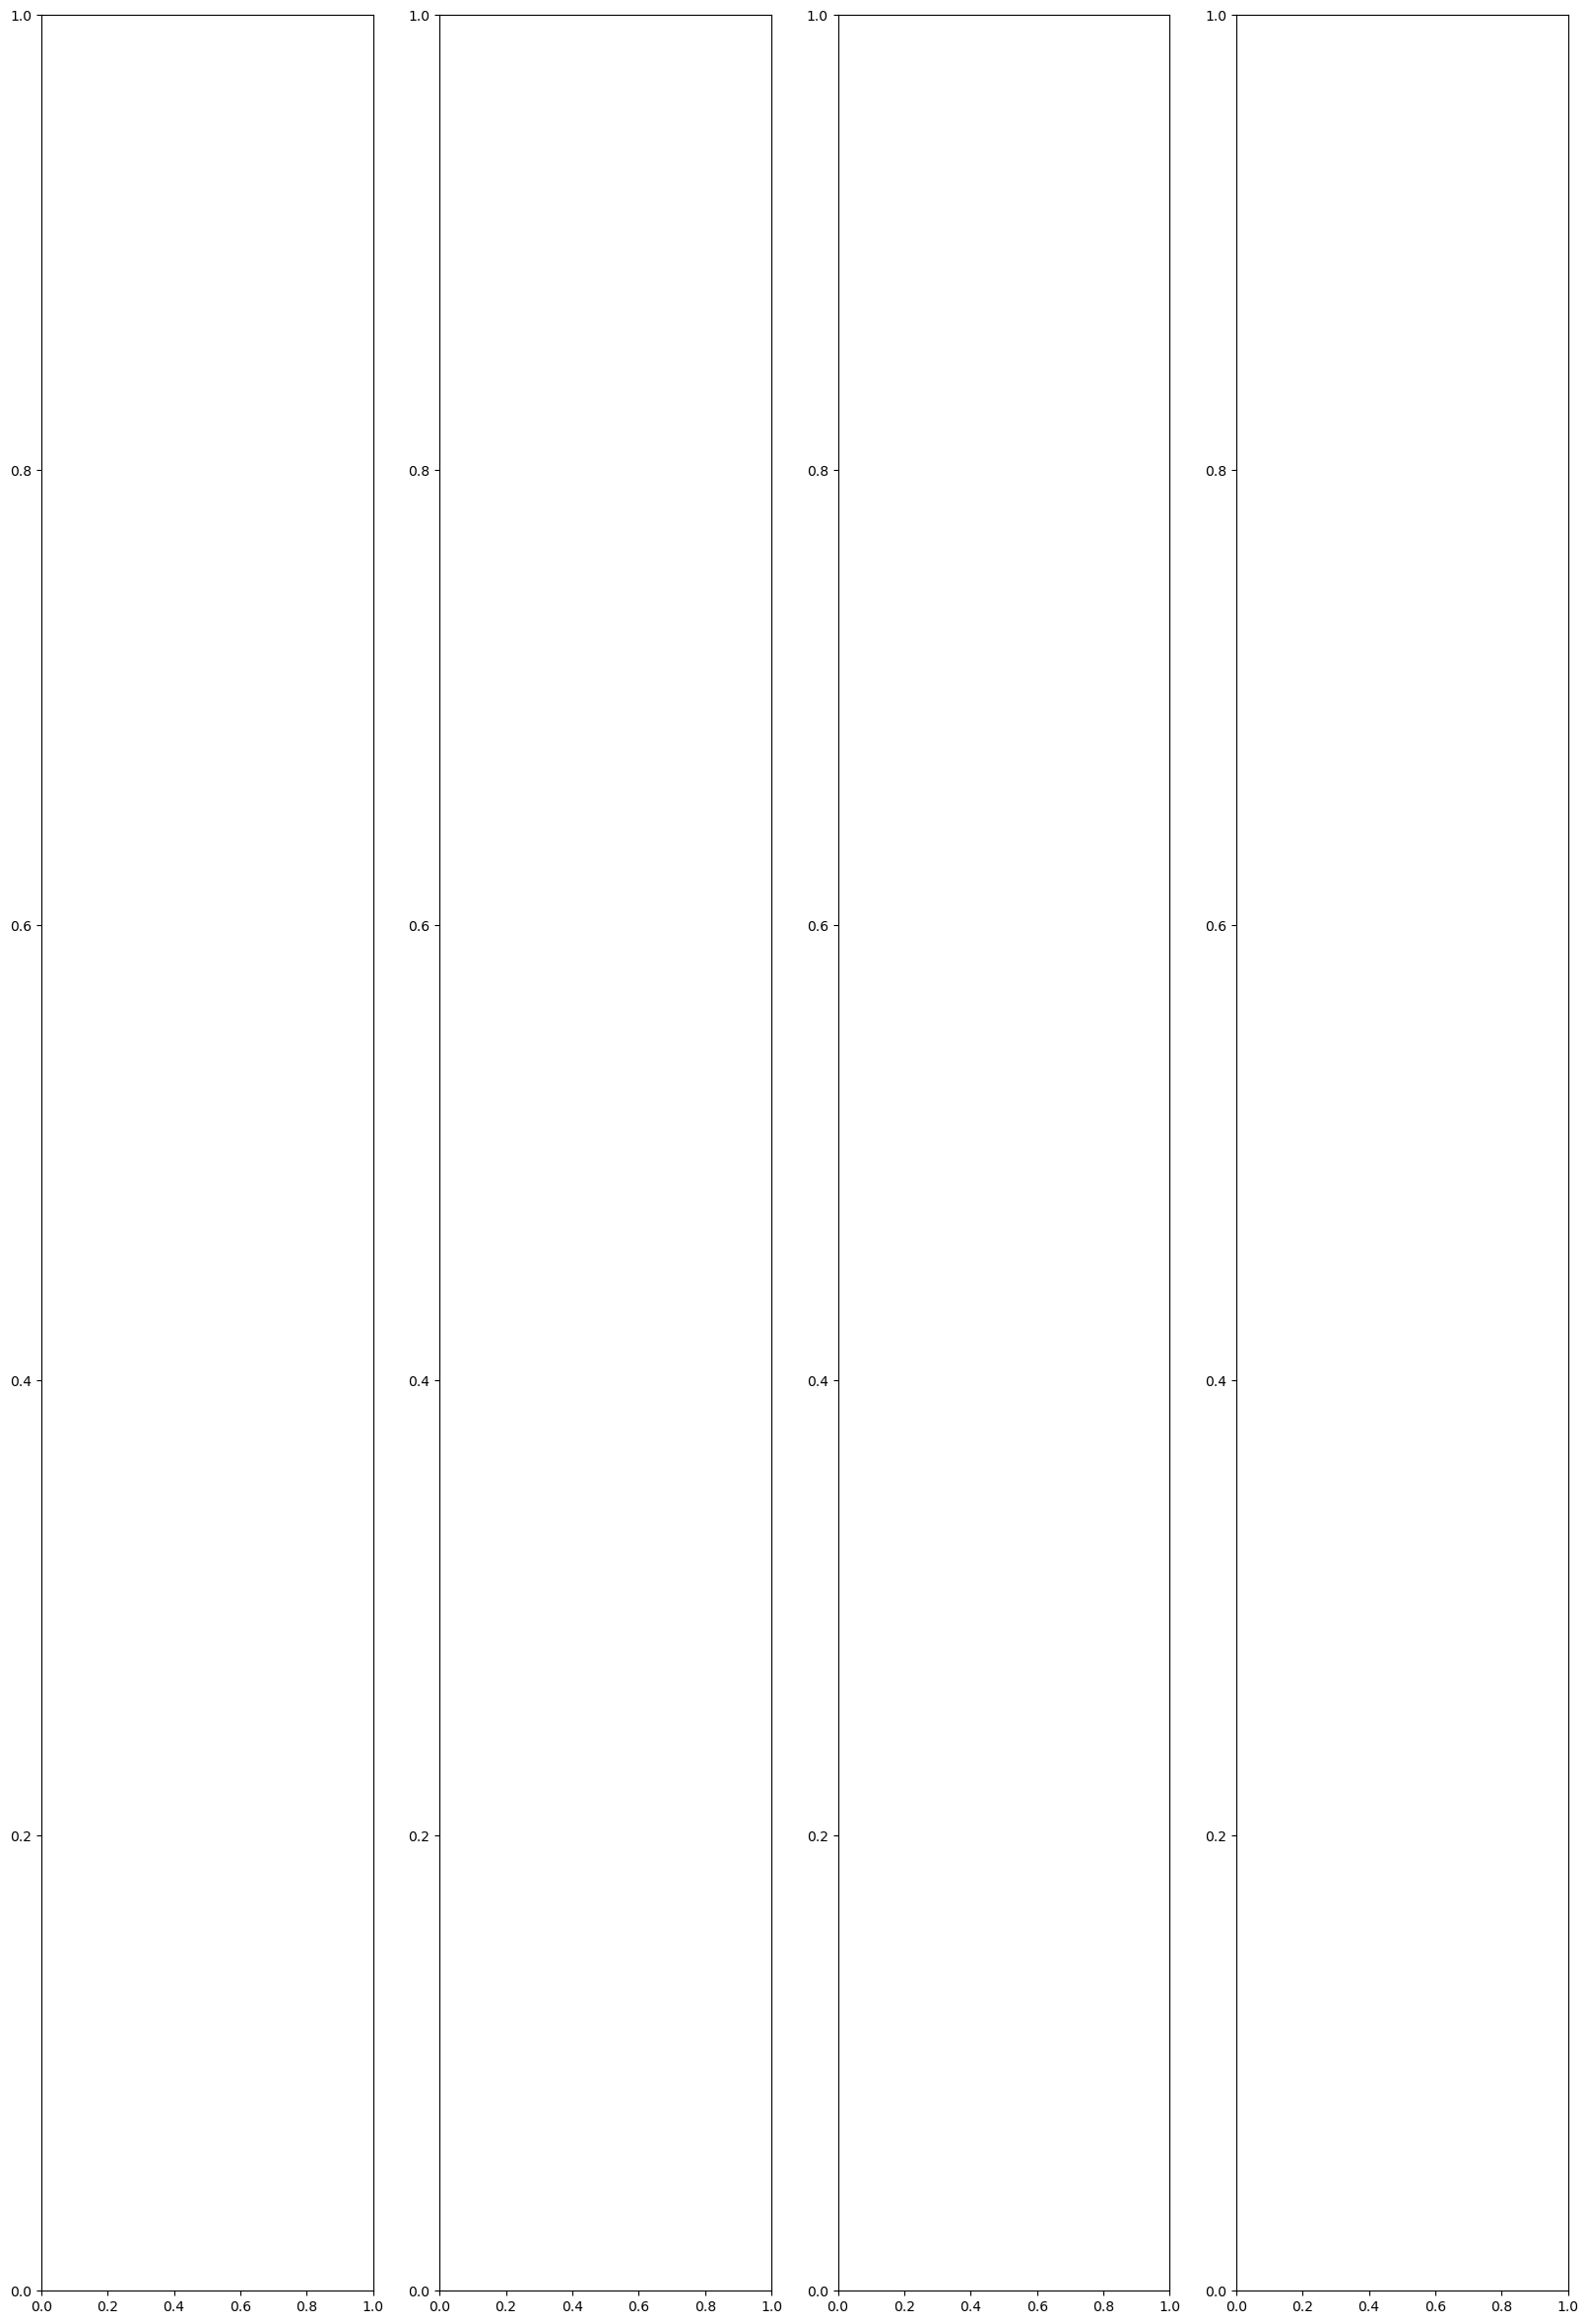

In [93]:
fig, ax = plt.subplots(ncols=4,figsize=(20,30))
for idx,image in enumerate(plot_images):
    pass
    #ax[idx].imshow(image)
#plt.show()

<h2>3. Partition Unaugmented Data</h2>

In [31]:
# manual partition
# 60-> train, 15 ->test, 15-> val


<h4>Move the Matching Labels</h4>
<h6>Due to this the labels gets moved to respective 3 folders created</h6>

In [32]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

<h2>4. Apply Image Augmentation on Images and Labels using Albumentations</h2>

<h4>4.A Setup Albumentations Transform Pipeline</h4>

In [33]:
import albumentations as alb

In [34]:
augmentor = alb.Compose([alb.RandomCrop(width=2000, height=2000), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

<h4>4.B Load a Test Image and Annotation with OpenCV and JSON</h4>

In [80]:
img = cv2.imread(os.path.join('data','train','images','IMG_20240612_202746.jpg'))

In [81]:
with open(os.path.join('data','train','labels','IMG_20240612_202746.json'),'r') as f:
    label = json.load(f)

In [82]:
label['shapes'][0]['points']

[[577.333333333333, 811.6666666666665],
 [2243.9999999999995, 2586.6666666666665]]

<h4>4.C Extract Coordinates and Rescale to Match Image Resolution</h4>

In [83]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [84]:
coords

[577.333333333333, 811.6666666666665, 2243.9999999999995, 2586.6666666666665]

In [85]:
# transform images for pascal_voc to albumentations format
# https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
IMAGE_DIMS = [3488,4640,3488,4640]
coords = list(np.divide(coords, IMAGE_DIMS))

In [86]:
coords


[0.1655198776758409, 0.1749281609195402, 0.6433486238532109, 0.557471264367816]

<h4>4.D Apply Augmentations and View Results</h4>

In [87]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [88]:
augmented['bboxes']

[(0.3505000000000002, 0.21033333333333326, 1.0, 1.0)]

In [91]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [2000,2000]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [2000,2000]).astype(int)), 
                    (255,0,0), 2)

#plt.imshow(augmented['image'])

array([[[201, 213, 215],
        [200, 212, 214],
        [200, 212, 214],
        ...,
        [200, 213, 227],
        [197, 210, 226],
        [190, 201, 221]],

       [[200, 212, 214],
        [200, 212, 214],
        [200, 212, 214],
        ...,
        [201, 214, 228],
        [198, 210, 228],
        [187, 200, 222]],

       [[199, 211, 213],
        [200, 212, 214],
        [200, 212, 214],
        ...,
        [201, 214, 228],
        [196, 208, 226],
        [185, 198, 220]],

       ...,

       [[154, 147, 144],
        [167, 162, 159],
        [185, 180, 177],
        ...,
        [ 52,  41,  37],
        [ 55,  44,  40],
        [255,   0,   0]],

       [[174, 167, 164],
        [192, 187, 184],
        [210, 205, 202],
        ...,
        [ 52,  41,  37],
        [ 55,  44,  40],
        [255,   0,   0]],

       [[188, 183, 182],
        [214, 209, 206],
        [231, 226, 223],
        ...,
        [255,   0,   0],
        [255,   0,   0],
        [255,   0,   0]]